# Load secret keys

In [1]:
import os
import json

In [2]:
def get_secrets():
    with open('../backend/secrets.json') as secrets_file:
        return json.load(secrets_file)
secrets = get_secrets()
os.environ["LANGSMITH_API_KEY"]  = secrets.get("LANGSMITH_API_KEY")
os.environ["GOOGLE_API_KEY"] = secrets.get("GOOGLE_API_KEY")
os.environ["GOOGLE_CSE_ID"] = secrets.get("GOOGLE_CSE_ID")
os.environ["LANGSMITH_TRACING"] = "true"

# Set-up LLama3.2 model locally

In [3]:
local_llm = "llama3.2"

# Generating local index

In [4]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_ollama import OllamaEmbeddings

USER_AGENT environment variable not set, consider setting it to identify your requests.


## Retrieving docs from web

In [5]:
urls = [
    "https://www.planetary.org/space-missions/curiosity",
    "https://www.rmg.co.uk/stories/topics/mars-nasa-rover-perseverance-facts-dates"
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)


## Transform text to embeddings

In [27]:
# Embedding Model
oembed = OllamaEmbeddings(base_url="http://localhost:11434", model="nomic-embed-text")
persist_directory = "../backend/chroma_langchain_db"
collection_name = "rag-chroma"

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name=collection_name,
    embedding=oembed,
    persist_directory=persist_directory
)
retriever = vectorstore.as_retriever()

# Intelligent Document Retrieval and Grading

In [7]:
### Retrieval Grader
from langchain_ollama import ChatOllama
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

In [8]:
# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing relevance 
    of a retrieved document to a user question. If the document contains keywords related to the user question, 
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
     <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "perseverance mission rover"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

{'score': 'yes'}


# Generate responses

In [9]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an assistant for question-answering tasks. 
    Use only and EXCLUSIVELY the following pieces of retrieved context to answer the question. 
    If you don't know the answer or if the provided context is not enough to answer the question, just say that you don't know. 
    Keep the answer concise and coherent. <|eot_id|><|start_header_id|>user<|end_header_id|>
    Question: {question} 
    Context: {context} 
    Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "document"],
)

llm = ChatOllama(model=local_llm, temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
question = "What can you tell me about Perseverance mission to Mars?"
docs = retriever.invoke(question)
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

The Perseverance rover is a NASA mission that landed on Mars on February 18, 2021, and is designed to search for signs of past and present life on the planet. Its four key objectives are:

1. Searching for signs of habitable conditions on Mars in the ancient past
2. Searching for signs of past microbial life itself
3. Testing out new technologies to aid future human missions to Mars
4. Producing oxygen on the Martian surface

The rover is equipped with state-of-the-art instruments and will perform numerous scientific experiments during its mission, which is intended to last at least two years.


# Detecting and correcting hallucinations

In [10]:
### Hallucination Grader

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template=""" <|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether 
    an answer is grounded in / supported by a set of facts. Give a binary 'yes' or 'no' score to indicate 
    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a 
    single key 'score' and no preamble or explanation. <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here are the facts:
    \n ------- \n
    {documents} 
    \n ------- \n
    Here is the answer: {generation}  <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm | JsonOutputParser()
hallucination_grader.invoke({"documents": docs, "generation": generation})

{'score': 'yes'}

In [11]:
### Answer Grader

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether an 
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is 
    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
     <|eot_id|><|start_header_id|>user<|end_header_id|> Here is the answer:
    \n ------- \n
    {generation} 
    \n ------- \n
    Here is the question: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm | JsonOutputParser()
answer_grader.invoke({"question": question, "generation": generation})

{'score': 'yes'}

In [12]:
### Router

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an expert at routing a 
    user question to a vectorstore or web search. Use the vectorstore for questions only and exclusively related to Curiosity or Perseverance missions to Mars.
    Otherwise, use web_search. 
    Note: Ignore any punctuation such as question marks or exclamation points when determining the appropriate datasource.
    You do not need to be stringent with the keywords in the question related to these topics. 
    Otherwise, use web-search. Give a binary choice 'web_search' or 'vectorstore' based on the question. 
    Return the a JSON with a single key 'datasource' and no premable or explanation. 
    
    Question to route: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question"],
)

question_router = prompt | llm | JsonOutputParser()
question = "What can you tell me about Obama?"

print(question_router.invoke({"question": question}))

{'datasource': 'web_search'}


# Fallback to Google Search

In [13]:
from langchain_google_community import GoogleSearchAPIWrapper
from langchain_core.tools import Tool

search = GoogleSearchAPIWrapper(k=3)
def search_results(query):
    return search.results(query, num_results=3)

web_search_tool = Tool(
    name="google_search",
    description="Search Google for recent results.",
    func=search_results
)
question = "Who is Obama?"
# search.results("Who is Obama?", num_results=3)
results = web_search_tool.invoke({"query": question})
results

[{'title': 'Barack Obama - Wikipedia',
  'link': 'https://en.wikipedia.org/wiki/Barack_Obama',
  'snippet': 'A member of the Democratic Party, he was the first African-American president. Obama previously served as a U.S. senator representing Illinois from 2005 to 2008\xa0...'},
 {'title': 'President Barack Obama | Barack Obama Presidential Library',
  'link': 'https://www.obamalibrary.gov/obamas/president-barack-obama',
  'snippet': 'Obama was elected the first African-American president of the Harvard Law Review, prior to graduating magna cum laude in 1991. He returned to Chicago in 1992\xa0...'},
 {'title': 'Barack Obama (@barackobama) • Instagram photos and videos',
  'link': 'https://www.instagram.com/barackobama/?hl=en',
  'snippet': 'Photo shared by Barack Obama on January 17, 2025 tagging @michelleobama. May be. Happy birthday to the love of my life, @MichelleObama. You fill every room with\xa0...'}]

# Creating the Graph Workflow

In [21]:
from typing_extensions import TypedDict
from typing import List
from langchain_core.documents import Document
from pprint import pprint
from langgraph.graph import END, StateGraph

### State
MAX_ATTEMPTS = 2

class GraphState(TypedDict):
    """
    Represents the state of our graph.
    
    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
        attempts: number of generation attempts
    """
    question: str
    generation: str
    web_search: str
    documents: List[str]
    attempts: int

### Nodes

def retrieve(state):
    print("---RETRIEVE---")
    question = state["question"]
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question, "attempts": state.get("attempts", 0)}

def generate(state):
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    attempts = state.get("attempts", 0) + 1
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation, "attempts": attempts}

def grade_documents(state):
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    filtered_docs = []
    web_search = "No"
    
    for d in documents:
        score = retrieval_grader.invoke({"question": question, "document": d.page_content})
        grade = score["score"]
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    
    return {"documents": filtered_docs, "question": question, "web_search": web_search, "attempts": state.get("attempts", 0)}

def web_search(state):
    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["snippet"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    print("Documents:")
    pprint(documents)
    return {"documents": documents, "question": question, "attempts": state.get("attempts", 0)}

def route_question(state):
    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    print(source["datasource"])
    if source["datasource"] == "web_search":
        return "websearch"
    return "vectorstore"

def decide_to_generate(state):
    print("---ASSESS GRADED DOCUMENTS---")
    if state["web_search"] == "Yes":
        print("---DECISION: INCLUDE WEB SEARCH---")
        return "websearch"
    print("---DECISION: GENERATE---")
    return "generate"

def grade_generation_v_documents_and_question(state):
    print("---CHECK HALLUCINATIONS---")
    attempts = state.get("attempts", 0)
    if attempts > MAX_ATTEMPTS:
        return "stop"
    
    score = hallucination_grader.invoke({"documents": state["documents"], "generation": state["generation"]})
    grade = score["score"]
    
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED---")
        score = answer_grader.invoke({"question": state["question"], "generation": state["generation"]})
        if score["score"] == "yes":
            return "useful"
        return "not useful"
    return "not supported"

def stop(state):
    return {"generation": "I'm sorry, I was not able to produce an answer", "attempts": state.get("attempts", 0)}


# Build Graph

In [22]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("stop", stop)  # stop

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)

workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
        "stop": "stop"
    },
)
workflow.add_edge("stop", END)


# Compile workflow

In [23]:
# Compile the workflow
app = workflow.compile()


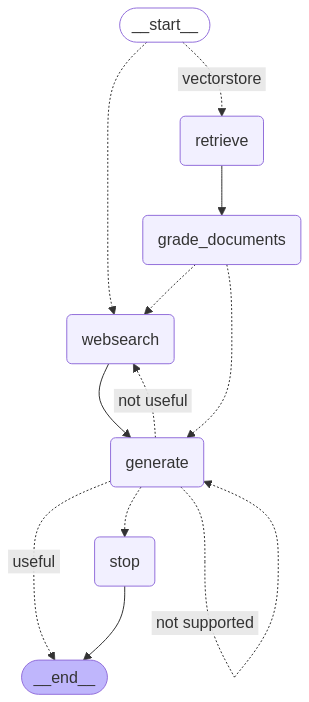

In [17]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)
    pass

In [18]:
# Testing the workflow

inputs = {"question": "What can you tell me about Perseverance mission?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
        if key in ["generate", "stop"]:
            pprint(value["generation"])


---ROUTE QUESTION---
vectorstore
---RETRIEVE---
'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: INCLUDE WEB SEARCH---
'Finished running: grade_documents:'
---WEB SEARCH---
'Finished running: websearch:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED---
'Finished running: generate:'
("The Perseverance mission is NASA's latest rover to Mars, designed to search "
 'for signs of past and present life on the planet. Its four key objectives '
 'are:\n'
 '\n'
 '1. Searching for signs of habitable conditions on Mars in the ancient past.\n'
 '2. Searching for signs of past microbial life itself.\n'
 '3. Testing out new technologies to aid future human missions to Mars.\n'
 '4. Producing oxygen on the Martian surface.\n'
 '\n'
 'The rover is intended to last at least two y

In [ ]:
inputs = {"question": "What can you tell me about Opportunity mission?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
        if key in ["generate", "stop"]:
            pprint(value["generation"])

---ROUTE QUESTION---
web_search
---WEB SEARCH---
'Finished running: websearch:'
---GENERATE---
---CHECK HALLUCINATIONS---
'Finished running: generate:'
('I don\'t know what the "Opportunity Mission" refers to based on the provided '
 'context. The text appears to be a conversation about a potential business '
 "deal or investment, but it doesn't provide any information about a specific "
 'space mission or program called "Opportunity".')
---GENERATE---
---CHECK HALLUCINATIONS---
'Finished running: generate:'
('I don\'t know what the "Opportunity Mission" refers to based on the provided '
 'context. The text appears to be a conversation about a potential business '
 "deal or investment, but it doesn't provide any information about a specific "
 'space mission or program called "Opportunity".')
---GENERATE---
---CHECK HALLUCINATIONS---
'Finished running: generate:'
('I don\'t know what the "Opportunity Mission" refers to based on the provided '
 'context. The text appears to be a convers

In [24]:
inputs = {"question": "Who was the first president of the USA?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
        if key in ["generate", "stop"]:
            pprint(value["generation"])

---ROUTE QUESTION---
web_search
---WEB SEARCH---
Documents:
[Document(metadata={}, page_content='On January 8, 1790, President George Washington delivered to Congress the first State of the Union address in American history. This precedent setting address\xa0...\n... of Confederation and consider the precedent-setting accomplishments of John Hanson, the first full-term “President of the United States in Congress Assembled.”\nGeorge Washington was a Founding Father and the first president of the United States, serving from 1789 to 1797. As commander of the Continental Army,\xa0...')]
'Finished running: websearch:'
---GENERATE---
---CHECK HALLUCINATIONS---
'Finished running: generate:'
'George Washington was the first president of the USA.'
---GENERATE---
---CHECK HALLUCINATIONS---
'Finished running: generate:'
'George Washington was the first president of the USA.'
---GENERATE---
---CHECK HALLUCINATIONS---
'Finished running: generate:'
'George Washington was the first president of the U